# Visualizing Science - Citation Network Clustering

ここではネットワークサイエンスの手法を用いて、論文の引用ネットワークを解析します。  
以下のコンテンツについて取り扱います。


*   1つの論文に注目したエゴネットワーク
*   1つの総合論文誌に注目したネットワーク
*   ネットワークのクラスタリング





pythonにはネットワーク解析に用いられるライブラリとしてnetworkxとigraphがありますが、今回は簡単にグラフを描画できるnetworkxを用います。

## TODO

1.   一つの論文についてエゴネットワーク（図）
2.   総合論文誌(sources)を一つ選んで全論文を取得
3.   論文の引用関係を取得
4.   クラスタリングしてネットワーク、論文に割り振られているconceptで色つけ（図）

## データの取得
前章で用いたOpenAlexを用いてまずはデータを取得します

In [1]:
%pip install pyalex
%pip install networkx
%pip install tqdm
%pip install japanize-matplotlib
%pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f36f4183a11a1a810ac0281382bec789989c69e57a422a46cd21ff54b81a704f
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import random
import time

# pyalex.config.email = "your@email.address"
pyalex.config.email = "hiroyasteven@gmail.com"

### 論文の引用関係を取得する
今回扱うネットワークは論文の引用関係を表したネットワークになります。
具体的には  
ノード：論文  
リンク：引用関係  
として表現されています。

今回は引用関係がリンクとなっていますので、「引用する側」と「引用される側」で区別することが可能であり、有向グラフと考えることができます。  


共引用も使ってみよう

In [3]:
# ある論文が引用されている論文を取得する関数
def get_cited_works(id):
    pager = Works().filter(cites=id).paginate(per_page=200)
    reference = []
    for page in pager:
        if len(page)>0:
            reference += page
    return reference

In [4]:
id = "W2741809807"
center_node = Works()[id]

# ある論文が引用している論文
cited_nodes = center_node["referenced_works"]
print(f"id「{id}」が引用している論文数：{len(cited_nodes)}")

# ある論文が引用されている論文
cited_by_nodes = get_cited_works(id)
print(f"id「{id}」が引用されている論文数：{len(cited_by_nodes)}")

id「W2741809807」が引用している論文数：35
id「W2741809807」が引用されている論文数：613


### 中心ノードが引用している論文のエゴネットワーク

まずは1つの論文に注目したエゴネットワークを見てみましょう。  
エゴネットワークとは、1つの中心ノードを出発点として直接繋がっているノード、2次の繋がり、3次の繋がりと見ていく手法です。

今回はある論文を引用している論文からなるエゴネットワークを見ていきましょう。

In [15]:
# edge_listからnetworkxのグラフを作成する関数
def create_graph_from_edge_list(edge_list, graph=None):
    if graph == None:
        graph = nx.Graph()
    for edge in edge_list:
        graph.add_edge(edge[0], edge[1])
    return graph

# グラフを描画する関数
def display_graph(graph, title, node_size=35):
    pos = nx.spring_layout(graph)  # レイアウトの計算
    plt.figure(figsize=(14,8))
    plt.title(title)
    nx.draw(graph, pos, with_labels=False, node_size=node_size, node_color="skyblue", font_size=10, font_weight="bold", width=0.3)  # 描画
    plt.show()  # グラフの表示

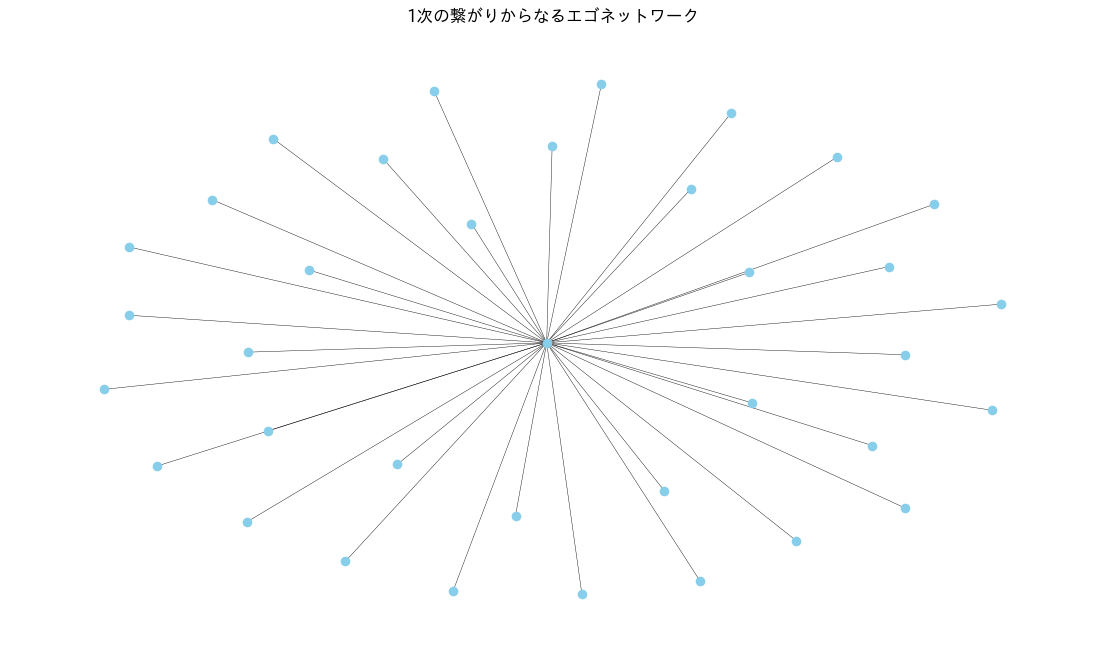

In [ ]:
#random.seed(42)

id = "W2741809807"
center_node = Works()[id]


# center_node = Works().random()
# id = center_node["id"]
cited_node_ids = center_node["referenced_works"]

# 論文の引用文献一覧
one_hop_edge_list = [(center_node["id"], cited_node_id) for cited_node_id in cited_node_ids]

# グラフの作成
one_hop_graph = create_graph_from_edge_list(one_hop_edge_list)

# グラフの描画
display_graph(graph = one_hop_graph, title = "1次の繋がりからなるエゴネットワーク")

上の図は1次の繋がりからなるエゴネットワークです。全てのノードが中心のノードと繋がっているため、エゴネットワークではこのような放射状のグラフになります。  
続いて2次の繋がりを見ていきましょう。

100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


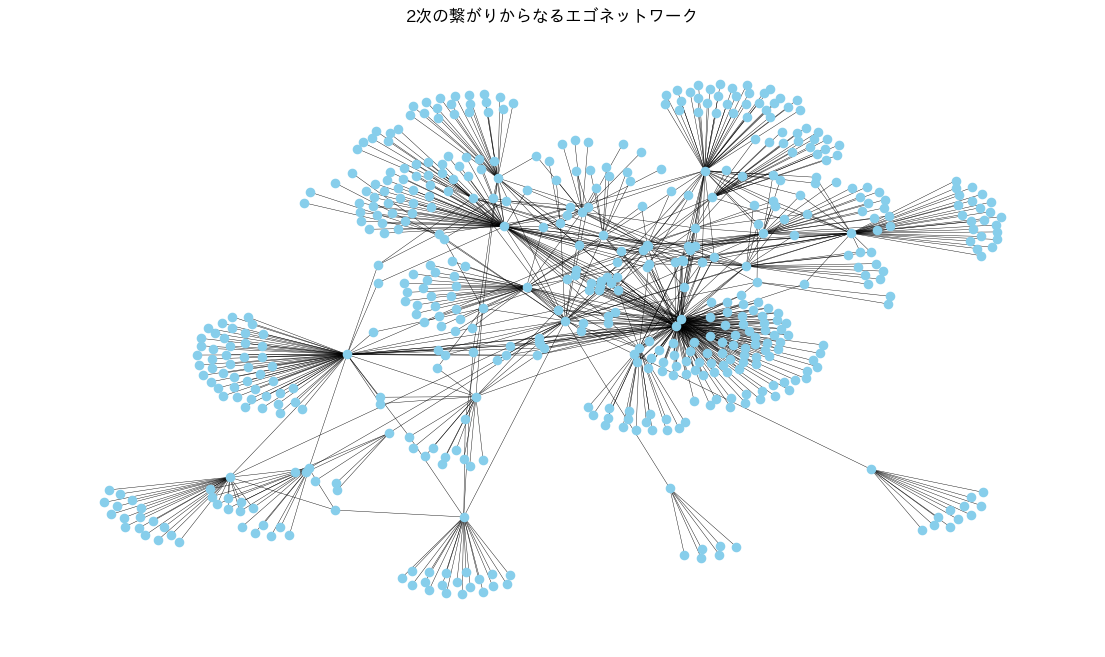

In [ ]:
# 1次のつながりのエッジ情報を記録
two_hop_edge_list = one_hop_edge_list.copy()
two_hop_node_ids = []

i = 0
for cited_node_id in tqdm(cited_node_ids):
    one_hop_node = Works()[cited_node_id]
    two_hop_node_ids += one_hop_node["referenced_works"]
    for two_hop_node_id in one_hop_node["referenced_works"]:
        two_hop_edge_list.append((cited_node_id, two_hop_node_id))


# グラフの作成
two_hop_graph = create_graph_from_edge_list(two_hop_edge_list)
# グラフの描画
display_graph(graph = two_hop_graph, title = "2次の繋がりからなるエゴネットワーク")

上のグラフからは少し特徴的なものが見えてきます。


*   中心部に固まっているのが1次のつながりのノード、縁の部分に分散しているのが2次のつながりのノード
*   一部の2次のつながりのノードはやや中心に近いところに位置してます。これらは他の2次のつながりの論文からも引用されており、



上までは引用関係を直接グラフで表していましたが、次に共引用という手法でネットワークを構築してみたいと思います。

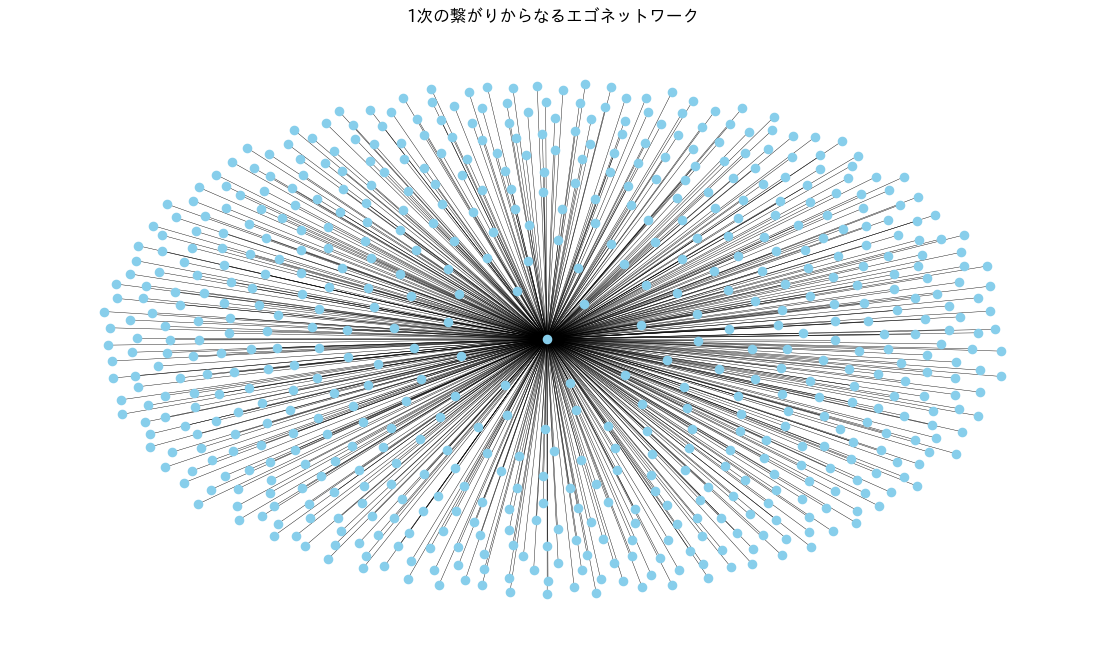

In [10]:
#random.seed(42)

id = "W2741809807"
center_node = Works()[id]
one_hop_nodes = get_cited_works(id)

# 論文の引用文献一覧
one_hop_edge_list = [(id, one_hop_node["id"]) for one_hop_node in one_hop_nodes]

# グラフの作成
one_hop_graph = create_graph_from_edge_list(one_hop_edge_list)

# グラフの描画
display_graph(graph = one_hop_graph, title = "1次の繋がりからなるエゴネットワーク")

100%|██████████| 613/613 [06:39<00:00,  1.53it/s]


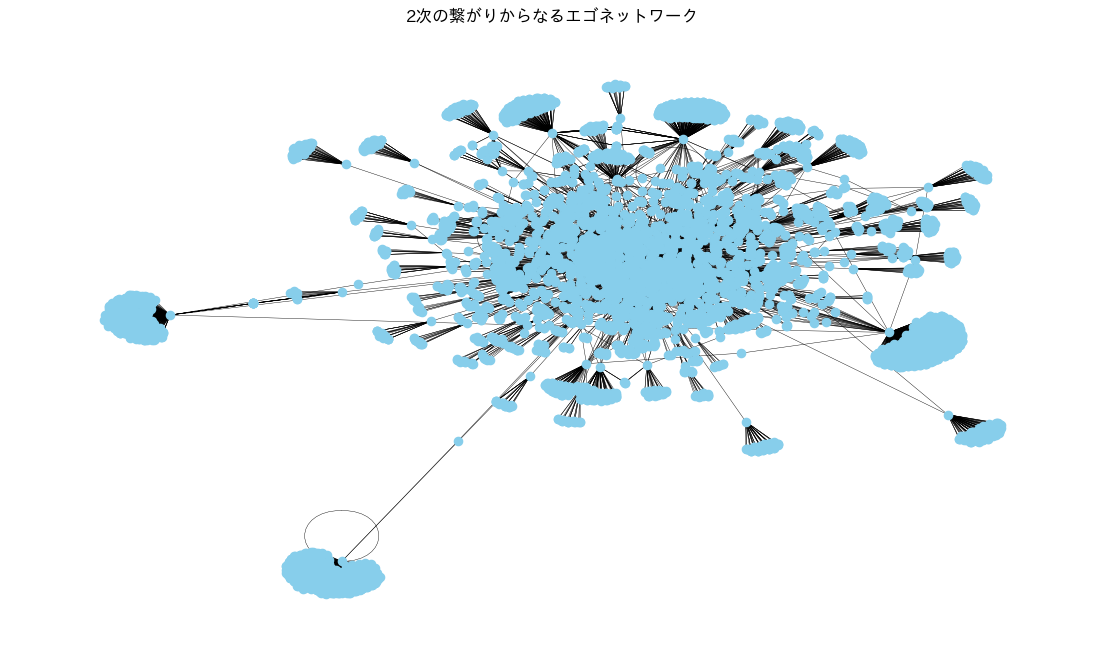

In [11]:
# 1次のつながりのエッジ情報を記録
two_hop_edge_list = one_hop_edge_list.copy()
two_hop_nodes = []

i = 0
for one_hop_node in tqdm(one_hop_nodes):
    two_hop_node_list = get_cited_works(one_hop_node["id"])
    two_hop_nodes += two_hop_node_list
    for two_hop_node in two_hop_node_list:
        two_hop_edge_list.append((one_hop_node["id"], two_hop_node["id"]))


# グラフの作成
two_hop_graph = create_graph_from_edge_list(two_hop_edge_list)
# グラフの描画
display_graph(graph = two_hop_graph, title = "2次の繋がりからなるエゴネットワーク")

# ネットワーク作成に7分、描画に1分30秒

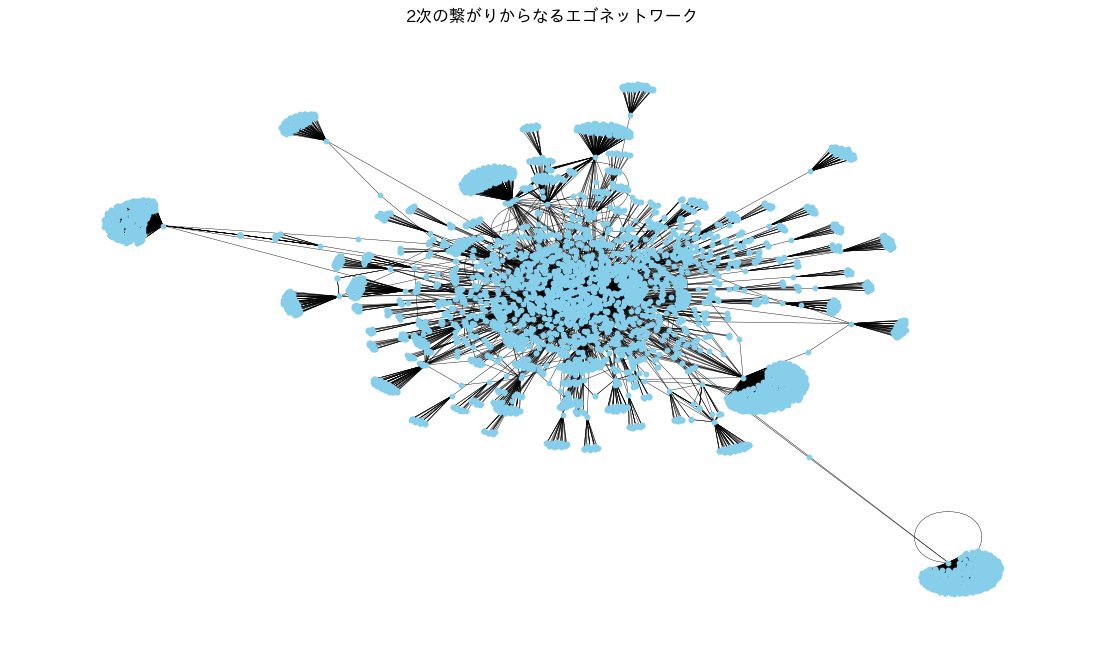

95.15940546989441


In [17]:
# グラフの描画
start_time = time.time()
display_graph(graph = two_hop_graph, title = "2次の繋がりからなるエゴネットワーク", node_size=10)
end_time = time.time()

print(f"{end_time - start_time}")

In [12]:
print(f"ノード数：{len(two_hop_nodes)}")
print(f"エッジ数：{len(two_hop_edge_list)}")

ノード数：5737
エッジ数：6350


## 1つの論文誌に注目したネットワーク

次に1つの論文誌に着目してネットワークを構築してみましょう。  

In [ ]:
source = Sources().filter(works_count=">1000000").get()[:10]
pd.DataFrame(map(lambda x: [x["id"],x["display_name"], x["host_organization_name"], x["is_oa"],x["works_count"]],source),
            columns=["id","論文誌名","論文誌発行機関","OA誌かどうか", "累計論文発行数"])

,id,論文誌名,論文誌発行機関,OA誌かどうか,累計論文発行数
0,https://openalex.org/S4306525036,PubMed,National Institutes of Health,False,33075864
1,https://openalex.org/S2764455111,PubMed Central,National Institutes of Health,True,8009760
2,https://openalex.org/S4306400806,Europe PMC (PubMed Central),European Bioinformatics Institute,True,5316266
3,https://openalex.org/S4306400194,arXiv (Cornell University),Cornell University,True,3015170
4,https://openalex.org/S4306401280,DOAJ (DOAJ: Directory of Open Access Journals),None,True,2672478
5,https://openalex.org/S4306402512,HAL (Le Centre pour la Communication Scientifi...,French National Centre for Scientific Research,True,2571027
6,https://openalex.org/S4306463937,Springer eBooks,None,False,2519831
7,https://openalex.org/S4306400562,Zenodo (CERN European Organization for Nuclear...,European Organization for Nuclear Research,True,1405433
8,https://openalex.org/S4306401271,RePEc: Research Papers in Economics,Federal Reserve Bank of St. Louis,True,1126422
9,https://openalex.org/S4210172589,Social Science Research Network,RELX Group (Netherlands),False,1079692


今回はSpringer eBooksの論文でネットワークを構築してみましょう。  
論文を取得する際に、論文誌のidが必要になるので上で判明したものを使います。

In [ ]:
def get_works_in_source(source_id):
    pager = Works().filter(locations={"source":{"id":source_id}}).paginate(per_page=200, n_max=100000)
    works = []
    for page in tqdm(pager):
        if len(page)>0:
            works += page
    return works

source_id = "https://openalex.org/S4306463937"

start_time = time.time()
springer_works = get_works_in_source(source_id)
end_time = time.time()
print(f"処理時間：{end_time - start_time}")

500it [10:16,  1.23s/it]

処理時間：616.9454061985016


ここではSpringer eBooks内の論文を10万サンプリングしたので、このノードを用いてネットワークを構築します。  

In [ ]:
# def check_match_source_id(work, source_id):
#     for location in work["locations"]:
#         if location["source"]["id"] == source_id:
#             return True
#     else:
#         return False

target_work_ids = [work["id"] for work in springer_works]
target_edge_list = []

for work in tqdm(springer_works):
    cited_work_ids = work["referenced_works"]
    for cited_work_id in cited_work_ids:
        if cited_work_id in target_work_ids:
            target_edge_list.append((cited_work_id, work["id"]))
target_edge_list

  2%|▏         | 1734/100000 [07:21<6:56:38,  3.93it/s]


KeyboardInterrupt: 

In [ ]:
# グラフの作成
springer_graph = create_graph_from_edge_list(target_edge_list)
# グラフの描画
display_graph(graph = springer_graph, title = "Springer eBooksからなる引用ネットワーク")

上記の結果を見ますと、引用関係が密に繋がっている部分と疎に繋がっている部分に分けられることがわかります。  

ネットワークにおいてノードが密に繋がっている構造はコミュニティ構造と呼ばれ、ネットワークの性質を分析するにあたって非常に重要なものになります。

次の章ではこのコミュニティ構造が何を表しているのかを深掘りするために、クラスタリングを実施します。

## 特定のFieldから論文を抽出

In [16]:
def get_works_in_field(field_id):
    pager = Works().filter(primary_topic={"field":{"id":field_id}}).paginate(per_page=200, n_max=200)
    works = []
    for page in tqdm(pager):
        if len(page)>0:
            works += page
    return works

field_id = 27

field_works = get_works_in_field(field_id)

1it [00:01,  1.63s/it]


In [ ]:
# 1hopまでのグラフ
one_hop_nodes = []
one_hop_edge_list = []

for field_work in field_works:
    id = field_work[id]
    one_hop_node_list = get_cited_works(id)
    one_hop_nodes += one_hop_node_list
    for one_hop_node in one_hop_node_list:

    # 論文の引用文献一覧
    one_hop_edge_list = [(id, one_hop_node["id"]) for one_hop_node in one_hop_nodes]

    # グラフの作成
    one_hop_graph = create_graph_from_edge_list(one_hop_edge_list)

    # グラフの描画
    display_graph(graph = one_hop_graph, title = "1次の繋がりからなるエゴネットワーク")

In [ ]:
# 2hopまでのグラフ

## 特定のKWに絞って論文を抽出

In [7]:
def get_works_in_field(field):
    pager = Works().filter(keywords={"keyword":field}).paginate(per_page=200, n_max=100000)
    works = []
    for page in tqdm(pager):
        if len(page)>0:
            works += page
    return works

keyword = "Machine Learning"#kinesin

start_time = time.time()
keyword_works = get_works_in_field(keyword)
end_time = time.time()
print(f"処理時間：{end_time - start_time}")

6it [00:05,  1.01it/s]

処理時間：5.968630790710449


In [8]:
len(keyword_works)

927

Topicsレベルで色分けを行なって見れば細かい粒度で見られるね。

## クラスタリングの実施

ネットワークにはノードが密集しているようなコミュニティ構造が見られることが多々あります。このような構造を有効に検出するための手法としてクラスタリングが挙げられます。  
ネットワークにおけるクラスタリング手法は様々ありますが、多くの場合モジュラリティという指標を最適化することでコミュニティ構造を検出することが可能となります。  

$$
Q = \frac{1}{2m} \sum_{i,j} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i, c_j)
$$

$Q$: モジュラリティ \\
$A_{ij}$: ノード$i$とノード$j$の接続関係を表す非負の値（0か1の二値で表現される） \\
$k_i$: ノード$i$の次数 \\
$c_i$: ノード $i$ が属するコミュニティ \\
$\delta(c_i, c_j)$: コミュニティ $c_i$ と $c_j$ が同じかどうかを示すδ関数（0か1の二値で表現される） \\
$m$: エッジの総数 \\

今回はモジュラリティを最適化するアルゴリズムの中でも、Louvain法と呼ばれる手法を用います。



In [ ]:
import leidenalg

# leiden法はランダム性があるので一貫した結果を得るためにseedを固定する
SEED = 42
random.seed(SEED)

def leiden_clustering(graph):
    # Leidenクラスタリングを実行
    partition = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition)
    # クラスタリング結果をノード属性に追加
    for node, cluster_id in enumerate(partition):
        graph.nodes[node]['cluster'] = cluster_id
    return graph

springer_graph = leiden_clustering(springer_graph)

AttributeError: 'Graph' object has no attribute 'vcount'

クラスタによってノードを色分けしたグラフは以下のようになります。

ネットワーク上でクラスタリング